In [1]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

# HSI data

## Traninig

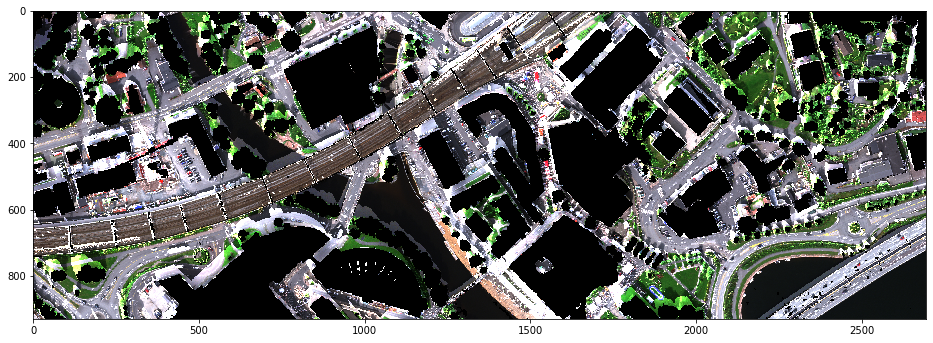

In [2]:
image = envi.open('../../hyperImage/reflectance/vnir/training/09_masked.hdr', '../../hyperImage/reflectance/vnir/training/09_masked.')
img = image.load()
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16))

In [3]:
img.shape

(930, 2694, 186)

In [4]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(image)
img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(930, 2694, 6)

In [5]:
ev = pc_0999.eigenvalues

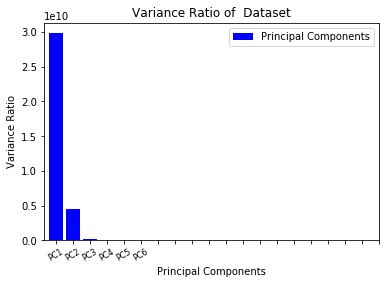

In [6]:
plt.bar([i for i in range(1, 7)],list(ev*100),label='Principal Components',color='b')
plt.legend()
plt.xlabel('Principal Components')
pc=[]
for i in range(6):
    pc.append('PC'+str(i+1))
#plt.xticks([1,2,3,4,5,6,7,8,9,10],pc, fontsize=8, rotation=30)
plt.xticks([i for i in range(1,21)],pc, fontsize=8, rotation=30)
plt.ylabel('Variance Ratio')
plt.title('Variance Ratio of  Dataset')
plt.show()

In [7]:
#NDVI calculation of the image 
vi = ndvi(image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [8]:
pc_img = img_pc.load()

In [9]:
img_pcc = img_pc[:,:,:3]
img_pcc.shape

(930, 2694, 3)

In [10]:
## Combine PCA,and ndvi DATA
df_pca = pd.DataFrame(img_pcc.reshape(-1, img_pcc.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, img_pcc.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)

In [11]:
main_df.to_csv('../../hyperImage/csv/features/HSI_feature', index=False)

In [3]:
main_df = pd.read_csv('../../hyperImage/csv/features/HSI_feature')

In [4]:
## Class image
gt_data = Image.open('../../hyperImage/reflectance/roi/class4.tif')

gt = np.array(gt_data)
gt.shape

(930, 2694)

In [5]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]
df_class.shape

(2505420, 1)

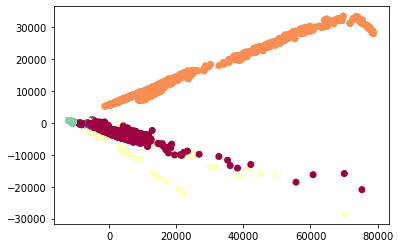

In [6]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

In [7]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [9]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.994475138121547

In [10]:
clf = SVC(gamma='auto')
clf.fit(X_scaled, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [12]:
y_pred = clf.predict(X_data_scaled)

In [13]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1561.0]
    G: [0.0, 1464.0]
    B: [0.0, 1117.0]
>

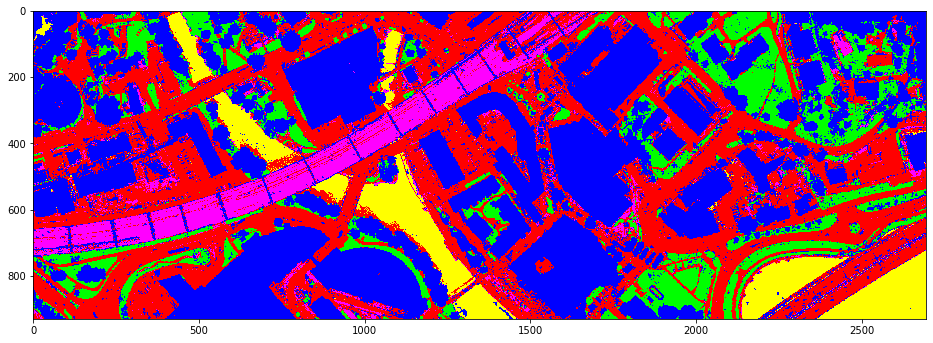

In [14]:
#full_image = envi.open('../hyperImage/reflectance/09_VNIR_POLISHED.hdr', '../hyperImage/reflectance/09_VNIR_POLISHED')
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [19]:
main_df_val = pd.read_csv('../../hyperImage/csv/features/HSI_feature_val')

In [20]:
main_df_val_scaled = scaler.transform(main_df_val)

In [21]:
hsi_val_pred = clf.predict(main_df_val_scaled)

In [22]:
predicted_hsi_mask_val = hsi_val_pred.reshape(val_image.shape[0], val_image.shape[1])

In [23]:
val_full_image = envi.open('../../hyperImage/reflectance/vnir/08_clipped.hdr', '../../hyperImage/reflectance/vnir/08_clipped.')

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [9.0, 1374.0]
    G: [7.0, 1732.0]
    B: [0.0, 822.0]
>

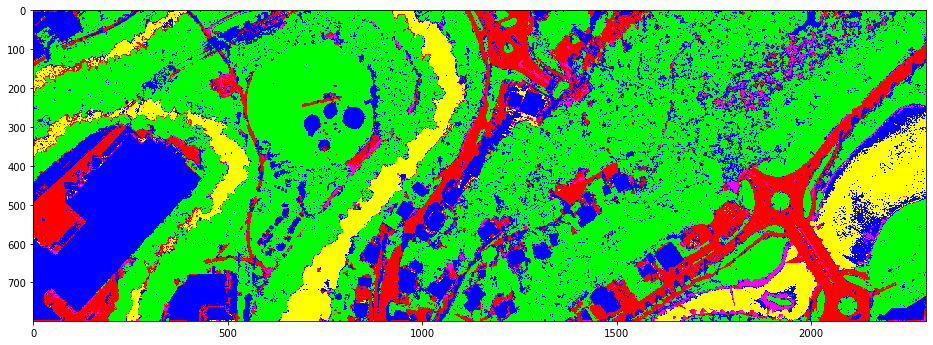

In [24]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [25]:
## Class image
gt_data_val = Image.open('../../hyperImage/reflectance/vnir/validation/class1.tif')
gt_val = np.array(gt_data_val)
gt_val.shape

(799, 2296)

In [26]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(1834504, 1)

In [27]:
df_hsi_val = pd.concat([main_df_val, df_class_val], axis=1, sort=False)

In [28]:
df_hsi_val_masked = df_hsi_val[(df_hsi_val[['Target']] != 0).all(axis=1)]
X_val = df_hsi_val_masked.drop(columns=['Target']).values
y_val = df_hsi_val_masked['Target'].values

In [29]:
X_data_scaled_val = scaler.transform(X_val)
y_pred = clf.predict(X_data_scaled_val)

In [30]:
accuracy_score(y_val, y_pred)

0.89840657848458

In [31]:
target_names = ['Road', 'Vegetation', 'Unclassified', 'Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.87      0.96      0.91     14624
  Vegetation       1.00      0.89      0.94    142122
Unclassified       0.55      0.98      0.70     24291
       Water       1.00      0.87      0.93     43573
 Train Track       0.00      0.00      0.00         1

    accuracy                           0.90    224611
   macro avg       0.68      0.74      0.70    224611
weighted avg       0.94      0.90      0.91    224611



In [32]:
cohen_kappa_score(y_val, y_pred)

0.8268402627466491

In [33]:
confusion_matrix(y_val, y_pred)

array([[ 14048,      2,    400,      0,    174],
       [  1512, 126007,  13596,      0,   1007],
       [   541,      0,  23730,      0,     20],
       [     0,      0,   5526,  38007,     40],
       [     0,      0,      1,      0,      0]])

# LIDAR DATA ONLY

# Training

In [131]:
import time
import os
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import math

In [34]:
point_cloud = pd.read_csv('../../hyperImage/csv/features/lidar_features')
          

In [35]:
point_cloud = pd.concat([point_cloud, df_class], axis=1, sort=False)

In [36]:
point_cloud = point_cloud.drop(['eigenentropy_50'], axis=1)

In [37]:
point_cloud.isnull().sum()

X                     0
Y                     0
Z                     0
Lidar Intensity       0
delta_z_50            0
std_z_50              0
radius_50             0
density_50            0
norm_z_50             0
linearity_50          0
planarity_50          0
sphericity_50         0
omnivariance_50       0
anisotropy_50         0
sum_eigenvalues_50    0
curvature_50          0
Target                0
dtype: int64

In [38]:
df_masked =  point_cloud[(point_cloud[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target', 'X', 'Y']).values
y = df_masked['Target'].values

In [39]:
scaler1 = MinMaxScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
clf1 = SVC(gamma='auto')
clf1.fit(X_train, y_train)
pred = clf1.predict(X_test)
accuracy_score(y_test, pred)

0.8965239410681399

In [140]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=110, max_features=0.25, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [142]:
X_data = point_cloud.drop(columns=['Target', 'X', 'Y']).values
X_data_scaled = scaler1.transform(X_data)

In [143]:
y_pred = random_forest3.predict(X_data_scaled)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1561.0]
    G: [0.0, 1464.0]
    B: [0.0, 1117.0]
>

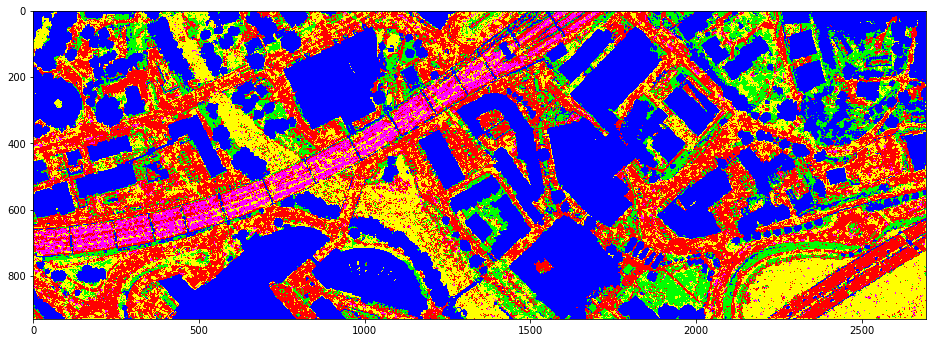

In [144]:
predicted_lidar_mask = y_pred.reshape(930, 2694)
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [40]:
point_cloud_val= pd.read_csv('../../hyperImage/csv/features/08val_lidar_features')

In [41]:
point_cloud_val = point_cloud_val.drop(columns=['eigenentropy_50', 'X', 'Y'])

In [42]:
X_data_val_scaled = scaler1.transform(point_cloud_val.values)

In [159]:
y_pred = random_forest3.predict(X_data_val_scaled)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [9.0, 1374.0]
    G: [7.0, 1732.0]
    B: [0.0, 822.0]
>

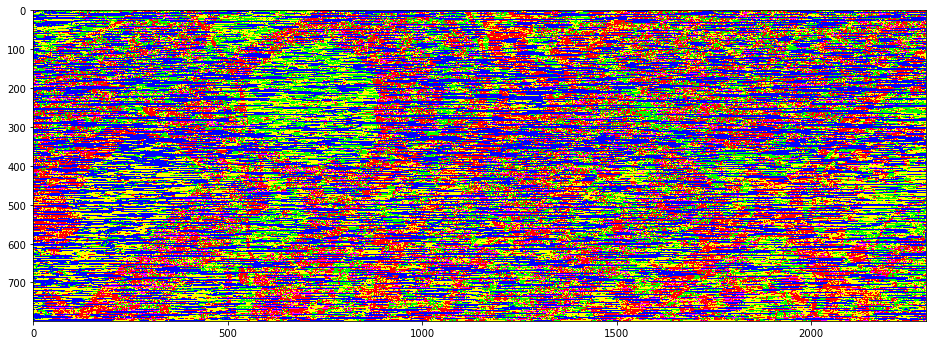

In [160]:
predicted_lidar_mask = y_pred.reshape(799, 2296)
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [161]:
df_lidar_val = pd.concat([point_cloud_val, df_class_val], axis=1, sort=False)

In [163]:
df_lidar_val_masked = df_lidar_val[(df_lidar_val[['Target']] != 0).all(axis=1)]
X_val = df_lidar_val_masked.drop(columns=['Target']).values
y_val = df_lidar_val_masked['Target'].values

In [165]:
X_data_scaled_val = scaler1.transform(X_val)
y_pred = random_forest3.predict(X_data_scaled_val)

In [166]:
accuracy_score(y_val, y_pred)

0.2709261790384264

In [168]:
target_names = ['Road', 'Vegetation', 'Unclassified', 'Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.15      0.45      0.23     14624
  Vegetation       0.73      0.21      0.33    142122
Unclassified       0.14      0.45      0.21     24291
       Water       0.27      0.30      0.29     43573
 Train Track       0.00      0.00      0.00         1

    accuracy                           0.27    224611
   macro avg       0.26      0.28      0.21    224611
weighted avg       0.54      0.27      0.30    224611



In [170]:
confusion_matrix(y_val, y_pred)

array([[ 6646,    41,  4340,  3048,   549],
       [29103, 29953, 52382, 23935,  6749],
       [ 1425,  2832, 11019,  9008,     7],
       [ 7213,  8366, 13509, 13235,  1250],
       [    1,     0,     0,     0,     0]])

In [171]:
cohen_kappa_score(y_val, y_pred)

0.0764851063181824

# HSI + LIDAR 

## Training 

In [43]:
df_lid_hsi = pd.concat([main_df,point_cloud], axis=1, sort=False)

In [44]:
df_lid_hsi

PC1         PC2        PC3      NDVI              X  \
0       -11951.570383  686.392356  65.298298  0.000000  584865.649777   
1       -11951.570383  686.392356  65.298298  0.000000  584865.949332   
2       -11951.570383  686.392356  65.298298  0.000000  584866.248886   
3       -11951.570383  686.392356  65.298298  0.000000  584866.548441   
4       -11951.570383  686.392356  65.298298  0.000000  584866.847996   
...               ...         ...        ...       ...            ...   
2505415 -11096.709604  153.344899 -32.933976 -0.214286  585671.152004   
2505416 -11096.324586  152.694146 -33.268110 -0.214286  585671.451559   
2505417 -11007.680193  207.827300 -68.165970 -0.297710  585671.751114   
2505418 -11015.184537  212.355488 -65.368807 -0.297710  585672.050668   
2505419 -11152.214743  124.040824 -40.542042 -0.236111  585672.350223   

                    Y        Z  Lidar Intensity  delta_z_50  std_z_50  ...  \
0        6.640449e+06 -9999.00          -9999.0        0.00  0.000000  ...   
1        6.640449e+06 -9999.00          -9999.0        0.00  0.000000  ...   
2        6.640449e+06 -9999.00          -9999.0        0.00  0.000000  ...   
3        6.640449e+06 -9999.00          -9999.0        0.00  0.000000  ...   
4        6.640449e+06 -9999.00          -9999.0        0.00  0.000000  ...   
...               ...      ...              ...         ...       ...  ...   
2505415  6.640172e+06    -0.02              6.0        0.11  0.041610  ...   
2505416  6.640172e+06    -0.02             11.0        0.11  0.043547  ...   
2505417  6.640172e+06     0.07             15.0        0.11  0.044432  ...   
2505418  6.640172e+06     0.07             10.0        0.11  0.043825  ...   
2505419  6.640172e+06     0.07             14.0        0.11  0.042396  ...   

         density_50  norm_z_50  linearity_50  planarity_50  sphericity_50  \
0          1.186564   1.000000      0.439295      0.560705       0.000000   
1          1.472931   1.000000      0.386697      0.613303       0.000000   
2          1.973445   1.000000      0.501464      0.498536       0.000000   
3          2.250352   1.000000      0.550589      0.449411       0.000000   
4          2.859038   1.000000      0.606650      0.393350       0.000000   
...             ...        ...           ...           ...            ...   
2505415    2.845995   0.998882      0.647100      0.352055       0.000845   
2505416    2.243675   0.998540      0.562208      0.436932       0.000860   
2505417    1.966244   0.998585      0.502864      0.496219       0.000918   
2505418    1.468506   0.998434      0.388593      0.610429       0.000978   
2505419    1.185953   0.998656      0.440237      0.558650       0.001113   

         omnivariance_50  anisotropy_50  sum_eigenvalues_50  curvature_50  \
0               0.000000       1.000000            0.798590      0.000000   
1               0.000000       1.000000            0.769188      0.000000   
2               0.000000       1.000000            0.805369      0.000000   
3               0.000000       1.000000            0.804713      0.000000   
4               0.000000       1.000000            0.835379      0.000000   
...                  ...            ...                 ...           ...   
2505415         0.049344       0.999155            0.853690      0.000731   
2505416         0.050192       0.999140            0.800986      0.000746   
2505417         0.051388       0.999082            0.807384      0.000759   
2505418         0.052256       0.999022            0.771148      0.000787   
2505419         0.054717       0.998887            0.800425      0.000891   

         Target  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
2505415       0  
2505416       0  
2505417       0  
2505418       0  
2505419       0  

[2505420 rows x 21 columns]

In [45]:
df_lidar_hsi = df_lid_hsi.drop(['X', 'Y'], axis=1)

In [46]:
df_lidar_hsi

PC1         PC2        PC3      NDVI        Z  \
0       -11951.570383  686.392356  65.298298  0.000000 -9999.00   
1       -11951.570383  686.392356  65.298298  0.000000 -9999.00   
2       -11951.570383  686.392356  65.298298  0.000000 -9999.00   
3       -11951.570383  686.392356  65.298298  0.000000 -9999.00   
4       -11951.570383  686.392356  65.298298  0.000000 -9999.00   
...               ...         ...        ...       ...      ...   
2505415 -11096.709604  153.344899 -32.933976 -0.214286    -0.02   
2505416 -11096.324586  152.694146 -33.268110 -0.214286    -0.02   
2505417 -11007.680193  207.827300 -68.165970 -0.297710     0.07   
2505418 -11015.184537  212.355488 -65.368807 -0.297710     0.07   
2505419 -11152.214743  124.040824 -40.542042 -0.236111     0.07   

         Lidar Intensity  delta_z_50  std_z_50  radius_50  density_50  \
0                -9999.0        0.00  0.000000   2.158722    1.186564   
1                -9999.0        0.00  0.000000   2.008629    1.472931   
2                -9999.0        0.00  0.000000   1.822016    1.973445   
3                -9999.0        0.00  0.000000   1.743989    2.250352   
4                -9999.0        0.00  0.000000   1.610227    2.859038   
...                  ...         ...       ...        ...         ...   
2505415              6.0        0.11  0.041610   1.612683    2.845995   
2505416             11.0        0.11  0.043547   1.745717    2.243675   
2505417             15.0        0.11  0.044432   1.824237    1.966244   
2505418             10.0        0.11  0.043825   2.010644    1.468506   
2505419             14.0        0.11  0.042396   2.159093    1.185953   

         norm_z_50  linearity_50  planarity_50  sphericity_50  \
0         1.000000      0.439295      0.560705       0.000000   
1         1.000000      0.386697      0.613303       0.000000   
2         1.000000      0.501464      0.498536       0.000000   
3         1.000000      0.550589      0.449411       0.000000   
4         1.000000      0.606650      0.393350       0.000000   
...            ...           ...           ...            ...   
2505415   0.998882      0.647100      0.352055       0.000845   
2505416   0.998540      0.562208      0.436932       0.000860   
2505417   0.998585      0.502864      0.496219       0.000918   
2505418   0.998434      0.388593      0.610429       0.000978   
2505419   0.998656      0.440237      0.558650       0.001113   

         omnivariance_50  anisotropy_50  sum_eigenvalues_50  curvature_50  \
0               0.000000       1.000000            0.798590      0.000000   
1               0.000000       1.000000            0.769188      0.000000   
2               0.000000       1.000000            0.805369      0.000000   
3               0.000000       1.000000            0.804713      0.000000   
4               0.000000       1.000000            0.835379      0.000000   
...                  ...            ...                 ...           ...   
2505415         0.049344       0.999155            0.853690      0.000731   
2505416         0.050192       0.999140            0.800986      0.000746   
2505417         0.051388       0.999082            0.807384      0.000759   
2505418         0.052256       0.999022            0.771148      0.000787   
2505419         0.054717       0.998887            0.800425      0.000891   

         Target  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
2505415       0  
2505416       0  
2505417       0  
2505418       0  
2505419       0  

[2505420 rows x 19 columns]

In [47]:
df_masked =  df_lidar_hsi[(df_lidar_hsi[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [48]:
scaler3 = MinMaxScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
clf2 = SVC(gamma='auto')
clf2.fit(X_train, y_train)
pred = clf2.predict(X_test)
accuracy_score(y_test, pred)

0.9659300184162063

In [50]:
clf2 = SVC(gamma='auto')
clf2.fit(X_scaled, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
X_data = df_lidar_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [52]:
y_pred = clf2.predict(X_data_scaled)

In [53]:
predicted_hsi_lidar_mask = y_pred.reshape(930, 2694)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1561.0]
    G: [0.0, 1464.0]
    B: [0.0, 1117.0]
>

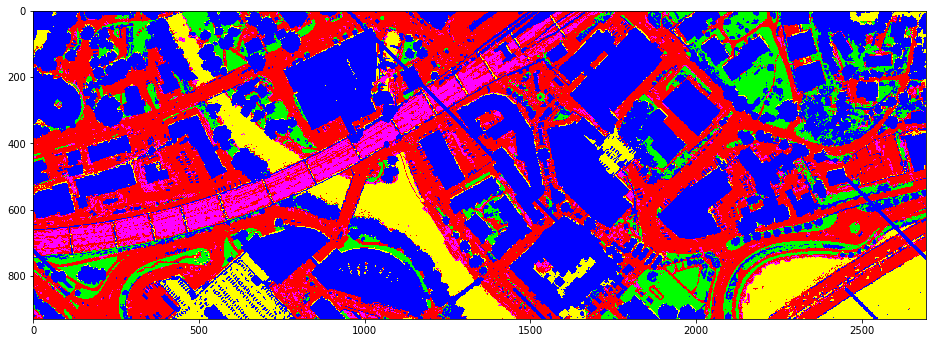

In [54]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [48]:
import scipy as sp


# Convenient functions
def compute_energy(proba,classes,beta):
    """
    The function compute the spatial energy terms of the Potts model
    classes: a 3x3 array containing the labels, the considered pixels is in the "middle" classes[1,1]
    proba:  the conditional probabilities of the considered pixels
    beta: the weight parameter
    """

    # Potts model
    count = (classes!=classes[1,1]).sum()

    # Add spectral and spatial energy
    energy = proba + beta*count

    return energy

# Main function
def icm_fit(proba,labels,beta=4,th=0.000001):
    """
    """
    # Get some parameters and do initialization
    diff = [1]
    niter = 0
    [nl,nc,C]=proba.shape

    # Iterate until convergence
    while (diff[-1] > th) and (niter < 100):
        old_labels= labels.copy() # Make a copy of the old labels
        for i in range(1,nl-1): # Scan each line
            for j in range(1,nc-1): # Scan each column
                energy = []
                labels_ = old_labels[i-1:i+2,j-1:j+2].copy()
                for c in range(C): # Compute the energy for the different classes
                    labels_[1,1] = c+1
                    energy.append(compute_energy(proba[i,j,c],labels_,beta))
                arg = sp.argmin(energy) # Get the maximum energy term for the local configuration
                labels[i,j] = arg + 1
        diff.append(1 - sp.sum(old_labels == labels ).astype(float)/nc/nl) # Compute the changes
        niter += 1
    # Clean data
    del old_labels
    return labels

In [ ]:
proba = -random_forest3.predict_log_proba(X_data_scaled).reshape(img.shape[0], img.shape[1],y.max())



In [ ]:
new_labels = icm_fit(proba,predicted_hsi_mask,beta=1.25,th=0.01)

In [ ]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=new_labels)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [98]:
road = (predicted_hsi_lidar_mask == 1).astype(int)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1561.0]
    G: [0.0, 1464.0]
    B: [0.0, 1117.0]
>

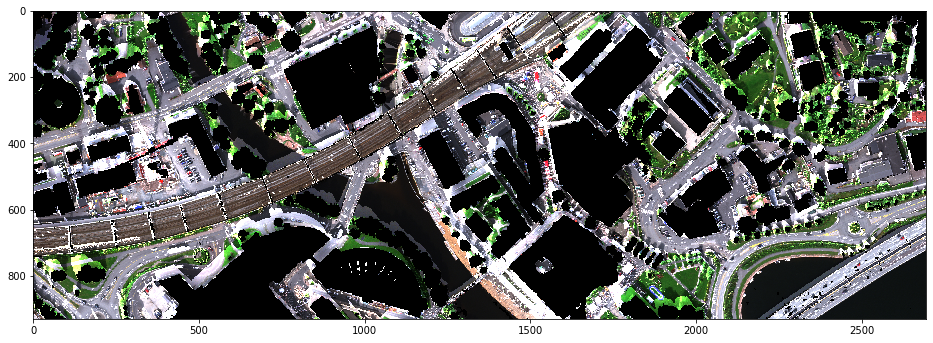

In [99]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation data 


In [55]:
val_image = envi.open('../../hyperImage/reflectance/vnir/validation/08_maskedd.hdr', '../../hyperImage/reflectance/vnir/validation/08_maskedd.')
val_img = val_image.load()
val_img.shape

(799, 2296, 186)

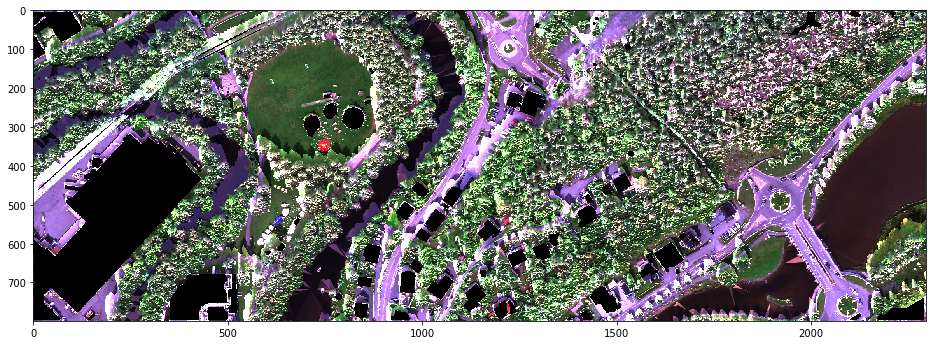

In [56]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16))

In [51]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
val_img_pc = pc_0999.transform(val_image)
val_img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(799, 2296, 6)

In [52]:
ev = pc_0999.eigenvalues

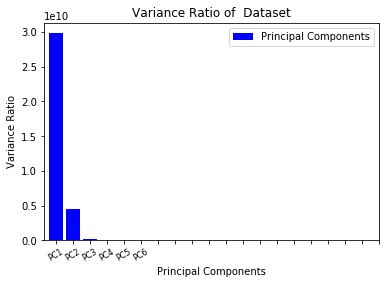

In [53]:
plt.bar([i for i in range(1, 7)],list(ev*100),label='Principal Components',color='b')
plt.legend()
plt.xlabel('Principal Components')
pc=[]
for i in range(6):
    pc.append('PC'+str(i+1))
#plt.xticks([1,2,3,4,5,6,7,8,9,10],pc, fontsize=8, rotation=30)
plt.xticks([i for i in range(1,21)],pc, fontsize=8, rotation=30)
plt.ylabel('Variance Ratio')
plt.title('Variance Ratio of  Dataset')
plt.show()

In [54]:
#NDVI calculation of the image 
vi = ndvi(val_image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [55]:
pc_img = val_img_pc[:,:,:3]
pc_img.shape

(799, 2296, 3)

In [56]:
## Combine PCA,and ndvi DATA
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)

In [57]:
main_df.to_csv('../../hyperImage/csv/features/HSI_feature_val', index=False)

In [57]:
main_df = pd.read_csv('../../hyperImage/csv/features/HSI_feature_val')

In [58]:
point_cloud_val= pd.read_csv('../../hyperImage/csv/features/08val_lidar_features')

In [59]:
df_lid_hsi = pd.concat([main_df, point_cloud_val], axis=1, sort=False)

In [60]:
df_lid_hsi.head(200)

PC1          PC2         PC3      NDVI              X  \
0    -1640.926828 -2937.241857 -551.400643 -0.038177  584802.750178   
1    -1415.556700 -2870.398349 -593.535074 -0.025015  584803.050135   
2    -1261.522435 -2923.494498 -598.297204 -0.025240  584803.350091   
3    -1313.560272 -2906.982408 -597.377752 -0.024155  584803.650047   
4     -778.840530 -2361.345489 -207.215110 -0.016812  584803.950004   
..            ...          ...         ...       ...            ...   
195   9050.598807  6857.635672  230.050578  0.612959  584861.241677   
196  10186.113813  7726.265223    9.100028  0.676759  584861.541633   
197  10000.999568  7674.220292    5.962862  0.677260  584861.841589   
198  12532.589042  8644.989099  -28.301162  0.688438  584862.141546   
199  12498.807505  8604.390780  -17.903047  0.686657  584862.441502   

                Y          Z  Lidar Intensity  delta_z_50  std_z_50  ...  \
0    6.640791e+06  29.969999             15.0         0.0       0.0  ...   
1    6.640791e+06  29.940001             15.0         0.0       0.0  ...   
2    6.640791e+06  29.940001             15.0         0.0       0.0  ...   
3    6.640791e+06  29.940001             14.0         0.0       0.0  ...   
4    6.640791e+06  29.940001             17.0         0.0       0.0  ...   
..            ...        ...              ...         ...       ...  ...   
195  6.640791e+06   0.000000              4.0         0.0       0.0  ...   
196  6.640791e+06   0.000000              4.0         0.0       0.0  ...   
197  6.640791e+06   0.000000              4.0         0.0       0.0  ...   
198  6.640791e+06  -0.010000              4.0         0.0       0.0  ...   
199  6.640791e+06  -0.010000              4.0         0.0       0.0  ...   

     density_50  norm_z_50  linearity_50  planarity_50  sphericity_50  \
0      1.186564        1.0      0.439295      0.560705            0.0   
1      1.472931        1.0      0.386697      0.613303            0.0   
2      1.973445        1.0      0.501464      0.498536            0.0   
3      2.250352        1.0      0.550589      0.449411            0.0   
4      2.859038        1.0      0.606650      0.393350            0.0   
..          ...        ...           ...           ...            ...   
195    3.350417        1.0      0.679783      0.320217            0.0   
196    3.350417        1.0      0.679783      0.320217            0.0   
197    3.350417        1.0      0.679783      0.320217            0.0   
198    2.859038        1.0      0.606650      0.393350            0.0   
199    2.250352        1.0      0.550589      0.449411            0.0   

     omnivariance_50  anisotropy_50  eigenentropy_50  sum_eigenvalues_50  \
0                0.0            1.0              NaN            0.798590   
1                0.0            1.0              NaN            0.769188   
2                0.0            1.0              NaN            0.805369   
3                0.0            1.0              NaN            0.804713   
4                0.0            1.0              NaN            0.835379   
..               ...            ...              ...                 ...   
195              0.0            1.0              NaN            0.894546   
196              0.0            1.0              NaN            0.894546   
197              0.0            1.0              NaN            0.894546   
198              0.0            1.0              NaN            0.835379   
199              0.0            1.0              NaN            0.804713   

     curvature_50  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
..            ...  
195           0.0  
196           0.0  
197           0.0  
198           0.0  
199           0.0  

[200 rows x 21 columns]

In [61]:
df_lid_hsi.isnull().sum()

PC1                        0
PC2                        0
PC3                        0
NDVI                       0
X                          0
Y                          0
Z                          0
Lidar Intensity            0
delta_z_50                 0
std_z_50                   0
radius_50                  0
density_50                 0
norm_z_50                  0
linearity_50               0
planarity_50               0
sphericity_50              0
omnivariance_50            0
anisotropy_50              0
eigenentropy_50       607685
sum_eigenvalues_50         0
curvature_50               0
dtype: int64

In [62]:
df_lid_his_ = df_lid_hsi.drop(columns=['eigenentropy_50', 'X', 'Y'])

In [63]:
X_data_scaled = scaler3.transform(df_lid_his_)

In [64]:
X_data_scaled

array([[1.13597112e-01, 4.13420066e-01, 3.97088068e-01, ...,
        1.00000000e+00, 3.28252970e-03, 0.00000000e+00],
       [1.16080118e-01, 4.14499959e-01, 3.93712394e-01, ...,
        1.00000000e+00, 1.88916436e-03, 0.00000000e+00],
       [1.17777185e-01, 4.13642162e-01, 3.93330868e-01, ...,
        1.00000000e+00, 3.60377524e-03, 0.00000000e+00],
       ...,
       [8.18603573e-02, 4.54417985e-01, 5.04118393e-01, ...,
        9.81436985e-01, 2.76919596e-04, 2.64603641e-02],
       [8.46893575e-02, 4.53753321e-01, 5.06649421e-01, ...,
        9.82540476e-01, 2.79633407e-04, 2.48845840e-02],
       [1.13637719e-01, 4.38983878e-01, 5.23728730e-01, ...,
        9.84603851e-01, 2.74932056e-04, 2.18897278e-02]])

In [65]:
val_pred_full = clf2.predict(X_data_scaled)

In [66]:
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])

In [67]:
val_full_image = envi.open('../../hyperImage/reflectance/vnir/08_clipped.hdr', '../../hyperImage/reflectance/vnir/08_clipped.')

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [9.0, 1374.0]
    G: [7.0, 1732.0]
    B: [0.0, 822.0]
>

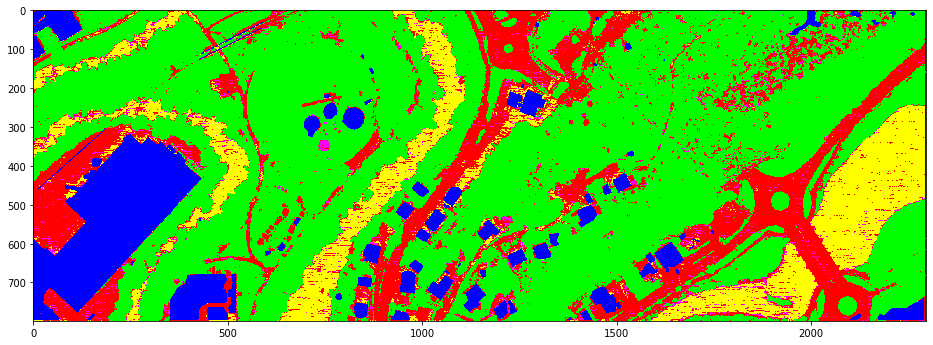

In [68]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [69]:
proba_val = -random_forest3.predict_log_proba(X_data_scaled).reshape(val_img.shape[0], val_img.shape[1],y.max())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:635: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [72]:
new_val_labels = icm_fit(proba_val,predicted_hsi_lidar_mask_val,beta=1.25,th=0.01)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: scipy.argmin is deprecated and will be removed in SciPy 2.0.0, use numpy.argmin instead


KeyboardInterrupt: 

In [ ]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=new_val_labels)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [ ]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16))

In [83]:
road = (predicted_hsi_lidar_mask_val == 0).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [9.0, 1374.0]
    G: [7.0, 1732.0]
    B: [0.0, 822.0]
>

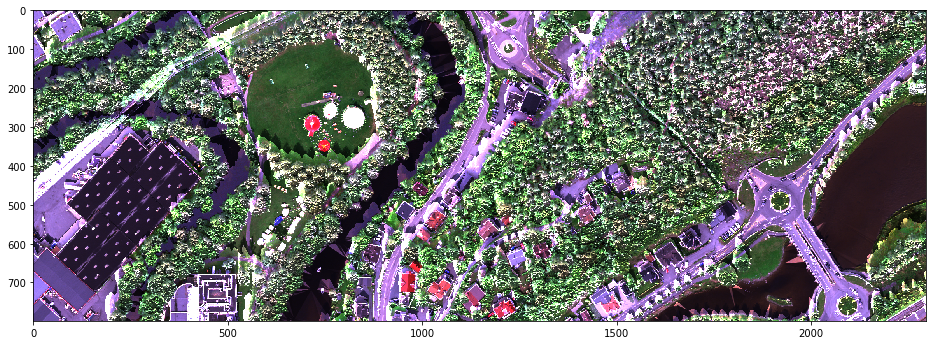

In [84]:
view = imshow(val_full_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [69]:
## Class image
gt_data_val = Image.open('../../hyperImage/reflectance/vnir/validation/class1.tif')

gt_val = np.array(gt_data_val)
gt_val.shape

(799, 2296)

In [70]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(1834504, 1)

In [71]:
df_lid_his_.shape

(1834504, 18)

In [72]:
df_val = pd.concat([df_lid_his_, df_class_val], axis=1, sort=False)


In [73]:
df_masked_val = df_val[(df_val[['Target']] != 0).all(axis=1)]


In [74]:
X_val = df_masked_val.drop(columns=['Target']).values
y_val = df_masked_val['Target'].values


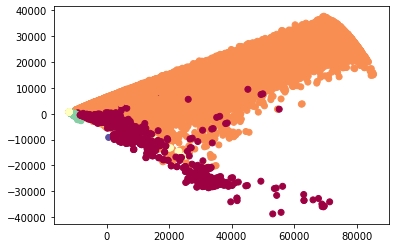

In [75]:
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='Spectral')
plt.show()

In [76]:
X_data_scaled_val = scaler3.transform(X_val)

In [77]:
val_pred_full_ = clf2.predict(X_data_scaled_val)

In [78]:
accuracy_score(y_val, val_pred_full_)

0.961662607797481

In [79]:
target_names = ['Road', 'Vegetation', 'Unclassified', 'Water', 'Train Track']

In [80]:
print(classification_report(y_val, val_pred_full_, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.67      0.97      0.79     14624
  Vegetation       1.00      0.96      0.98    142122
Unclassified       1.00      0.97      0.98     24291
       Water       1.00      0.95      0.97     43573
 Train Track       0.00      0.00      0.00         1

    accuracy                           0.96    224611
   macro avg       0.73      0.77      0.75    224611
weighted avg       0.98      0.96      0.97    224611



In [81]:
cohen_kappa_score(y_val, val_pred_full_)

0.9317227100641167

In [82]:
confusion_matrix(y_val, val_pred_full_)

array([[ 14209,      8,      0,     10,    397],
       [  4592, 136672,    116,     76,    666],
       [   615,      0,  23663,      0,     13],
       [  1756,      0,      0,  41456,    361],
       [     1,      0,      0,      0,      0]])